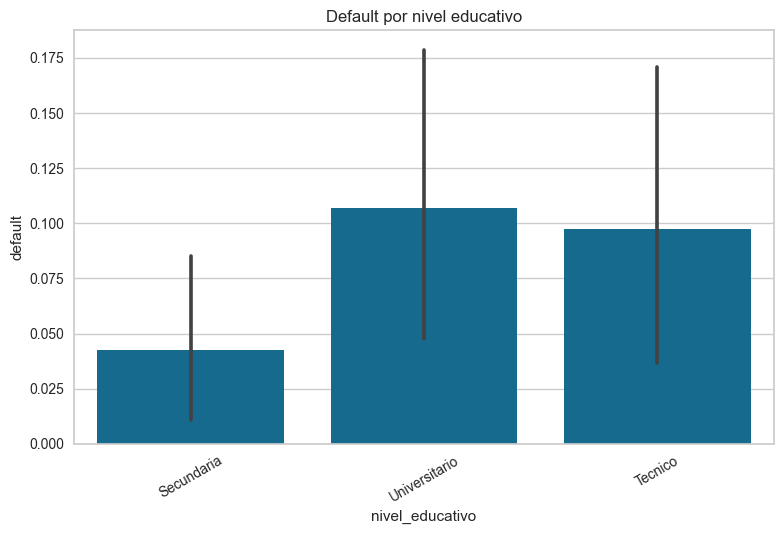

TypeError: setup() got an unexpected keyword argument 'feature_interaction'

In [1]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargar la data
df = pd.read_csv("caso6_prestamos_personales.csv")

# 2. Análisis exploratorio y posibles sesgos por nivel educativo
sns.barplot(data=df, x='nivel_educativo', y='default')
plt.title("Default por nivel educativo")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 3. Feature engineering no trivial
df['riesgo_cuota'] = df['cuota_vs_ingreso'] * df['ingreso_mensual'] / df['tiempo_laboral_meses']
df['estabilidad_laboral'] = pd.cut(df['tiempo_laboral_meses'], bins=[0, 12, 36, 120, 240],
                                   labels=['Nuevo', 'Intermedio', 'Estable', 'Veterano'])

# 4. Configuración PyCaret con enfoque explicativo y ético
clf = setup(data=df,
            target='default',
            session_id=2025,
            categorical_features=['hist_crediticia', 'nivel_educativo', 'estabilidad_laboral'],
            ignore_features=['cuota_vs_ingreso'],  # ya se incluye en otra variable
            transformation=True,
            polynomial_features=True,
            bin_numeric_features=['edad', 'ingreso_mensual'],
            feature_interaction=True,
            remove_multicollinearity=True,
            multicollinearity_threshold=0.85,
            silent=True)

# 5. Comparación por Recall (prioriza detectar malos clientes)
best_model = compare_models(sort='Recall')

# 6. Ajustar y afinar con F1 score
final = tune_model(best_model, optimize='F1')
evaluate_model(final)
interpret_model(final)

# 7. Simular un cliente en riesgo y mejorar su perfil
cliente_riesgoso = pd.DataFrame({
    'edad': [24],
    'ingreso_mensual': [1500],
    'hist_crediticia': ['Regular'],
    'nivel_educativo': ['Tecnico'],
    'tiempo_laboral_meses': [6],
    'riesgo_cuota': [600 * 1500 / 6],  # cuota vs ingreso estimado
    'estabilidad_laboral': ['Nuevo']
})

cliente_mejorado = cliente_riesgoso.copy()
cliente_mejorado['ingreso_mensual'] = 2500
cliente_mejorado['tiempo_laboral_meses'] = 24
cliente_mejorado['riesgo_cuota'] = 600 * 2500 / 24
cliente_mejorado['estabilidad_laboral'] = 'Intermedio'

print("🔍 Riesgo actual:")
print(predict_model(final, data=cliente_riesgoso))

print("Riesgo si mejora estabilidad:")
print(predict_model(final, data=cliente_mejorado))

# 8. Exportar modelo para conectarlo con API externa
save_model(final, 'modelo_scoring_credito_final')
